<table class="table table-bordered">
    <tr>
        <th style="text-align:center; width:25%"><img src='https://www.np.edu.sg/PublishingImages/Pages/default/odp/ICT.jpg' style="width: 250px; height: 125px; "></th>
        <th style="text-align:center;"><h1>Deep Learning</h1><h2>Assignment 2  (Problem 2) - Character Generator Model (Individual)</h2><h3>AY2021/22 Semester</h3></th>
    </tr>
</table>

In [1]:
# Import the Required Packages

#Basic python packages
import numpy as np
import pandas as pd
import nltk
import re
import string

#loading and preprocessing data
import tensorflow.keras
import os, shutil
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

#model making
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import SimpleRNN
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import GRU
from tensorflow.keras.layers import Dropout
import random
import sys

#optimizers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD

#regularizer
from tensorflow.keras import regularizers

## Step 1 – Data Loading and Processing

### 1.1 Data Loading

In [2]:
#path to holmes.txt
path = 'holmes.txt' 

text = open(path).read().lower()
print(text)

ï»¿the adventures of sherlock holmes by sir arthur conan doyle

   i. a scandal in bohemia
  ii. the red-headed league
 iii. a case of identity
  iv. the boscombe valley mystery
   v. the five orange pips
  vi. the man with the twisted lip
 vii. the adventure of the blue carbuncle
viii. the adventure of the speckled band
  ix. the adventure of the engineer's thumb
   x. the adventure of the noble bachelor
  xi. the adventure of the beryl coronet
 xii. the adventure of the copper beeches


adventure i. a scandal in bohemia

i.

to sherlock holmes she is always the woman. i have seldom heard
him mention her under any other name. in his eyes she eclipses
and predominates the whole of her sex. it was not that he felt
any emotion akin to love for irene adler. all emotions, and that
one particularly, were abhorrent to his cold, precise but
admirably balanced mind. he was, i take it, the most perfect
reasoning and observing machine that the world has seen, but as a
lover he would have placed 

### 1.2 Data Processing


In [3]:
# Length of extracted character sequences
maxlen = 60

# We sample a new sequence every `step` characters
step = 3

# This holds our extracted sequences
sentences = []

# This holds the targets (the follow-up characters)
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

# List of unique characters in the corpus
chars = sorted(list(set(text)))
print('Unique characters:', len(chars))
# Dictionary mapping unique characters to their index in `chars`
char_indices = dict((char, chars.index(char)) for char in chars)

# Next, one-hot encode the characters into binary arrays.
print('Vectorization...')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Number of sequences: 187460
Unique characters: 59
Vectorization...


## Step 2 – Develop Character Generator Model

In [4]:
# Build the Model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(maxlen, len(chars))))
model.add(Dropout(0.4))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(128))
model.add(Dense(len(chars), activation='softmax'))

In [6]:
# Train the Model
optimizer = optimizers.RMSprop(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

history = model.fit(x, y,
              batch_size=256,
              epochs=50,
              validation_split=0.2)

Train on 149968 samples, validate on 37492 samples
Epoch 1/50
149968/149968 [==============================] - 38s 252us/sample - loss: 2.7914 - acc: 0.2182 - val_loss: 2.4134 - val_acc: 0.2979
Epoch 2/50
149968/149968 [==============================] - 28s 186us/sample - loss: 2.3173 - acc: 0.3243 - val_loss: 2.1801 - val_acc: 0.3591
Epoch 3/50
149968/149968 [==============================] - 28s 186us/sample - loss: 2.1626 - acc: 0.3658 - val_loss: 2.0499 - val_acc: 0.3985
Epoch 4/50
149968/149968 [==============================] - 28s 185us/sample - loss: 2.0582 - acc: 0.3924 - val_loss: 1.9716 - val_acc: 0.4142
Epoch 5/50
149968/149968 [==============================] - 28s 186us/sample - loss: 1.9797 - acc: 0.4149 - val_loss: 1.8893 - val_acc: 0.4387
Epoch 6/50
149968/149968 [==============================] - 28s 185us/sample - loss: 1.9161 - acc: 0.4309 - val_loss: 1.8360 - val_acc: 0.4508
Epoch 7/50
149968/149968 [==============================] - 28s 185us/sample - loss: 1.8679

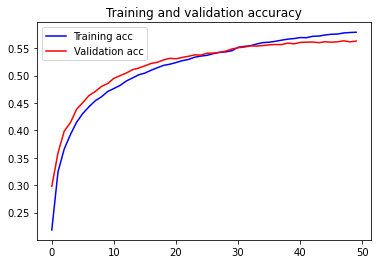

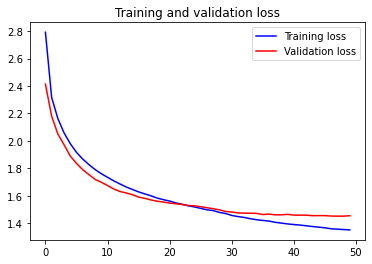

In [7]:
# Plot the Training and Validation Accuracy & Loss Scores
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show() 

In [8]:
model.save('text_generator_weights.h5')

In [112]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas) #return to the selected "next character"

for epoch in range(1):
    # Select a text seed at random
    start_index = random.randint(0, len(text) - maxlen - 1)
    generated_text_initial = text[start_index: start_index + maxlen]
    print('--- Generating with seed: "' + generated_text_initial + '"')

    for temperature in [0.6, 0.7, 0.8, 0.9]:
        generated_text = generated_text_initial
        print()
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
    print()

--- Generating with seed: "doned his
attempts to establish himself in practice in londo"

------ temperature: 0.6
doned his
attempts to establish himself in practice in london, a small
against the door when he spoke that he was a perfortion and
question of a courte and stepfather had been leds a problem which
had a small matter in which seemed to the morning was position,
but i was a courtery some dore and was a small barder remain
of a ground of the the way, and he heard the man, the is the
years 'what she see that the fire was as sole the becone upon
his womat of br

------ temperature: 0.7
doned his
attempts to establish himself in practice in londow there, the
tain of the boich and game in a disible to him. he had come upon
the points of the scool of some london.

"well, as i think the man was deteal the house to his dear story
coming which was the good of the idea of the room of the street.

"well, you may receeded a left his criming of the weakon which
i master some of his hand t

## Step 3 – Use the developed Model to generate the characters / sentences

In [13]:
# takes the user input
text_input = input()

which must always be associated in my mind with my wooing, a


In [15]:
# Use the Best Model to generate 400 characters
model.load_weights('text_generator_weights.h5')

def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature # take a log function and then divided by temperature
    exp_preds = np.exp(preds) # take a exp function
    preds = exp_preds / np.sum(exp_preds) # normalize to 1
    probas = np.random.multinomial(1, preds, 1) # roll a dice based on the probability distribution in preds
    return np.argmax(probas) #return to the selected "next character"

for epoch in range(1):
    # Select a text seed at random
    print('--- Generating with seed: "' + text_input + '"')

    for temperature in [0.6]:
        generated_text = text_input
        print()
        print('------ temperature:', temperature)
        sys.stdout.write(generated_text)

        # We generate 400 characters
        for i in range(400):
            sampled = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(generated_text):
                sampled[0, t, char_indices[char]] = 1.

            preds = model.predict(sampled, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = chars[next_index]

            generated_text += next_char
            generated_text = generated_text[1:]

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()
    print()

--- Generating with seed: "which must always be associated in my mind with my wooing, a"

------ temperature: 0.6
which must always be associated in my mind with my wooing, and there is
for a woman which was a hands from the street of a cure of
the door. it was a small polies and stranged out of the wood
of the door, in the tants which was from my pracestant at the
objection of the hard and had had been the man who light the weight
upon his own station. in the friend of a hand of the house.

"it was nothing character completed was convented a considerable
weather. the

